In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
'''
import libraries
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
# nltk.download('all')
# Add the NLTK data directory to the paths
# nltk.data.path.append('/Library/Frameworks/Python.framework/Versions/3.12/nltk_data')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.5.0+cu121
True


In [4]:
data_dir = '/content/drive/MyDrive/data/collection_with_abstracts.csv'
df = pd.read_csv(data_dir)
df.head()


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract
0,39435445,Editorial: The operationalization of cognitive...,"Winter M, Probst T, Tallon M, Schobel J, Pryss R.",Front Neurosci. 2024 Oct 7;18:1501636. doi: 10...,Winter M,Front Neurosci,2024,2024/10/22,PMC11491427,NaN,10.3389/fnins.2024.1501636,NaN
1,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...
2,39390053,Multi-scale input layers and dense decoder agg...,"Lan X, Jin W.",Sci Rep. 2024 Oct 10;14(1):23729. doi: 10.1038...,Lan X,Sci Rep,2024,2024/10/10,PMC11467340,NaN,10.1038/s41598-024-74701-0,Accurate segmentation of COVID-19 lesions from...
3,39367648,An initial game-theoretic assessment of enhanc...,"Fatemi MY, Lu Y, Diallo AB, Srinivasan G, Azhe...",Brief Bioinform. 2024 Sep 23;25(6):bbae476. do...,Fatemi MY,Brief Bioinform,2024,2024/10/05,PMC11452536,NaN,10.1093/bib/bbae476,The application of deep learning to spatial tr...
4,39363262,Truncated M13 phage for smart detection of E. ...,"Yuan J, Zhu H, Li S, Thierry B, Yang CT, Zhang...",J Nanobiotechnology. 2024 Oct 3;22(1):599. doi...,Yuan J,J Nanobiotechnology,2024,2024/10/04,PMC11451008,NaN,10.1186/s12951-024-02881-y,BACKGROUND: The urgent need for affordable and...


In [5]:
'''
Check for missing values
'''
df['Abstract'].isna().sum()

213

In [6]:
'''
check for duplicates
'''
df['DOI'].nunique()

10969

In [7]:
'''
missing values in Abstract column
'''

nrow = df.shape[0]
nnullAb = df.Abstract.isna().sum()
(nnullAb/nrow ) * 100

1.8602620087336246

In [8]:
# Drop rows where 'Abstract' column has missing values
print(f'df before removal::{df.shape}')
df_cleaned = df.dropna(subset=['Abstract'])
print(f'df after removal::{df_cleaned.shape}')
print(f'# rows removed = {df.shape[0] - df_cleaned.shape[0]}')

df before removal::(11450, 12)
df after removal::(11237, 12)
# rows removed = 213


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
from pprint import pprint
import re

In [11]:
df_cleaned['titleAbstract'] = df_cleaned['Title'] + ' ' + df_cleaned['Abstract']
df_cleaned.head(2)


<ipython-input-11-46d8a4228191>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['titleAbstract'] = df_cleaned['Title'] + ' ' + df_cleaned['Abstract']


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract,titleAbstract
1,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...
2,39390053,Multi-scale input layers and dense decoder agg...,"Lan X, Jin W.",Sci Rep. 2024 Oct 10;14(1):23729. doi: 10.1038...,Lan X,Sci Rep,2024,2024/10/10,PMC11467340,NaN,10.1038/s41598-024-74701-0,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...


In [12]:
import nltk
# nltk.download('punkt')

In [13]:
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [14]:
# Example text
text = "This is a sentence test."
tokens = word_tokenize(text)
print(tokens)

['This', 'is', 'a', 'sentence', 'test', '.']


In [15]:
df_cleaned_lem = df_cleaned.copy()

en_stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = re.sub(r'[^A-Za-z1-9 ]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)

    clean_text = []
    for token in tokens:
        if token not in en_stopwords:
            clean_text.append(lemmatizer.lemmatize(token))
    return ' '.join(clean_text)

In [16]:
df_cleaned['titleAbstractNew'] = df_cleaned['titleAbstract'].apply(lemmatize_text)

<ipython-input-16-c7a2265cafad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['titleAbstractNew'] = df_cleaned['titleAbstract'].apply(lemmatize_text)


In [17]:
df_cleaned.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract,titleAbstract,titleAbstractNew
1,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,characterization arteriosclerosis based comput...
2,39390053,Multi-scale input layers and dense decoder agg...,"Lan X, Jin W.",Sci Rep. 2024 Oct 10;14(1):23729. doi: 10.1038...,Lan X,Sci Rep,2024,2024/10/10,PMC11467340,NaN,10.1038/s41598-024-74701-0,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...,multi scale input layer dense decoder aggregat...


In [18]:
deep_learning_keywords = ['deep learning', 'deep neural networks', 'neural network', 'artificial neural network',
                          'feedforward neural network', 'neural net algorithm',
                          'multilayer perceptron', 'convolutional neural network', 'cnn',
                          'recurrent neural network', 'rnn', 'long short-term memory network',
                          'lstm', 'transformer', 'transformer models', 'transformer-based model',
                          'self-attention models', 'attention-based neural networks']

computer_vision_keywords = ['computer vision', 'vision model', 'image processing',
                          'vision algorithms', 'object recognition', 'scene understanding']

nlp_keywords = ['natural language processing', 'text mining', 'nlp',
                'computational linguistics', 'language processing',
                'text analytics', 'textual data analysis', 'text data analysis',
                'text analysis', 'speech and language technology',
                'language modeling', 'computational semantics']

llm_keywords = ['large language model',
                'pretrained language model', 'generative language model',
                'foundation model', 'state-of-the-art language model']


keywords = deep_learning_keywords + computer_vision_keywords + nlp_keywords + llm_keywords

In [19]:
lemmatized_keywords = {
    'Deep Learning': [lemmatize_text(keyword) for keyword in deep_learning_keywords],
    'Computer Vision': [lemmatize_text(keyword) for keyword in computer_vision_keywords],
    'NLP': [lemmatize_text(keyword) for keyword in nlp_keywords],
    'LLM': [lemmatize_text(keyword) for keyword in llm_keywords],
}

In [20]:
# Reset the index of the DataFrame
df_cleaned.reset_index(drop=True, inplace=True)

In [21]:
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertModel
import torch

# Load the pre-trained SciBERT model
#tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
# model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

model.to(device)

def get_embedding(text):
    # Tokenize and get embeddings
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Test embedding function on the title and abstract of the first paper
example_title_embedding = get_embedding(df_cleaned['Title'][0])
example_abstract_embedding = get_embedding(df_cleaned['Abstract'][0])
example_titleabstract_embedding = get_embedding(df_cleaned['titleAbstract'][0])
example_titleabstractnew_embedding = get_embedding(df_cleaned['titleAbstractNew'][0])

print("Title Embedding Shape:", example_title_embedding.shape)
print("Abstract Embedding Shape:", example_abstract_embedding.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Title Embedding Shape: (1, 768)
Abstract Embedding Shape: (1, 768)


In [22]:
import numpy as np
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
en_stopwords = set(stopwords.words('english'))

# Define keyword variations
keyword_variations = {
    'deep learning': deep_learning_keywords,
    'computer vision': computer_vision_keywords,
    'natural language processing': nlp_keywords,
    'large language model': llm_keywords
}

def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    for standard, variations in keyword_variations.items():
        for variation in variations:
            # Replace variations with the standard term
            text = re.sub(r'\b' + re.escape(variation) + r'\b', standard, text)
    return text

def contains_keywords(text):
    # Normalize text for keyword checking
    normalized_text = normalize_text(text)
    for method in keyword_variations.keys():
        if method in normalized_text:
            return True
    return False

# Function to calculate weighted cosine similarity
def calculate_weighted_similarity(embeddings, query_vector):
    # Calculate the cosine similarity
    similarities = cosine_similarity(embeddings, query_vector)

    # Apply penalty for papers that do not contain relevant keywords
    for i in range(similarities.shape[0]):
        paper_text = df_cleaned['titleAbstractNew'].iloc[i]
        if not contains_keywords(paper_text):  # If no keywords are found
            similarities[i] *= 0.1  # Apply a penalty by reducing the score

    return similarities

# Assuming df_cleaned is already defined and contains a 'titleAbstractNew' column
# Apply get_embedding to each titleAbstractNew and ensure it returns a 2D array
df_cleaned.loc[:, 'titleAbstractNew_Embedding'] = df_cleaned['titleAbstractNew'].apply(lambda x: get_embedding(x))

# Ensure the embeddings are in the correct shape
# Convert the list of embeddings into a 2D NumPy array
embeddings_matrix = np.vstack(df_cleaned['titleAbstractNew_Embedding'].values)

# Create a query vector from the keywords and ensure it's 2D
query_vector = get_embedding(" ".join(keyword_variations.keys())).reshape(1, -1)

# Calculate weighted cosine similarity
weighted_similarities = calculate_weighted_similarity(embeddings_matrix, query_vector)

# Assign the results back to the DataFrame using .loc to avoid warnings
df_cleaned.loc[:, 'titleAbstractNew_Similarity'] = weighted_similarities.flatten()

# Display similarity scores
print(df_cleaned[['Title', 'titleAbstractNew', 'titleAbstractNew_Similarity']].head(2))


<ipython-input-22-6d8910ef56c2>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'titleAbstractNew_Embedding'] = df_cleaned['titleAbstractNew'].apply(lambda x: get_embedding(x))


                                               Title  \
0  Characterization of arteriosclerosis based on ...   
1  Multi-scale input layers and dense decoder agg...   

                                    titleAbstractNew  \
0  characterization arteriosclerosis based comput...   
1  multi scale input layer dense decoder aggregat...   

   titleAbstractNew_Similarity  
0                     0.593806  
1                     0.595254  


<ipython-input-22-6d8910ef56c2>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'titleAbstractNew_Similarity'] = weighted_similarities.flatten()


In [23]:
df_cleaned.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract,titleAbstract,titleAbstractNew,titleAbstractNew_Embedding,titleAbstractNew_Similarity
0,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,characterization arteriosclerosis based comput...,"[[-0.33896586, 0.101144746, 0.2964446, -0.0717...",0.593806
1,39390053,Multi-scale input layers and dense decoder agg...,"Lan X, Jin W.",Sci Rep. 2024 Oct 10;14(1):23729. doi: 10.1038...,Lan X,Sci Rep,2024,2024/10/10,PMC11467340,NaN,10.1038/s41598-024-74701-0,Accurate segmentation of COVID-19 lesions from...,Multi-scale input layers and dense decoder agg...,multi scale input layer dense decoder aggregat...,"[[-0.28026462, 0.18662411, 0.2740965, -0.10312...",0.595254


In [24]:
# Set a threshold for filtering
similarity_threshold = 0.4
revelant_data = df_cleaned[(df_cleaned['titleAbstractNew_Similarity'] > similarity_threshold)]
irrrevelant_data = df_cleaned[(df_cleaned['titleAbstractNew_Similarity'] <= similarity_threshold)]

In [25]:
revelant_data.shape, irrrevelant_data.shape

((6805, 16), (4432, 16))

In [81]:
row_id = 5719
revelant_data.reset_index(drop=True, inplace=True)
pprint(revelant_data['titleAbstractNew_Similarity'][row_id])
pprint(revelant_data.Abstract[row_id])

0.63484824
('Aims: To capture the complex relationships between risk factors and cancer '
 'incidences in the US and predict future cancer burden. Materials &amp; '
 'methods: Two artificial neural network (ANN) algorithms were adopted: a '
 'multilayer feed-forward network (MLFFNN) and a nonlinear autoregressive '
 'network with eXogenous inputs (NARX). Data on the incidence of the four most '
 'common tumors (breast, colorectal, lung and prostate) from 1992 to 2016 '
 '(available from National Cancer Institute online datasets) were used for '
 'training and validation, and data until 2050 were predicted. Results: The '
 'rapid decreasing trend of prostate cancer incidence started in 2010 will '
 'continue until 2018-2019;\xa0it will then slow down and reach a plateau '
 'after 2050, with several differences among\xa0ethnicities. The incidence of '
 'breast cancer will reach a plateau in 2030, whereas\xa0colorectal cancer '
 'incidence will reach a minimum value of 35 per\xa0100,000 i

In [29]:
keyword_dict = {
    'Deep Learning': deep_learning_keywords,
    'Computer Vision': computer_vision_keywords,
    'NLP': nlp_keywords,
    'LLM': llm_keywords
}

def classify_paper(text):

    for method, keywords in keyword_dict.items():
        if any(keyword in text for keyword in keywords):
            return method  # Return the first matching method

    return 'Others'  # If no keywords match

# Apply classification function to each paper
revelant_data['method_type'] = revelant_data.apply(lambda row: classify_paper(row['titleAbstractNew']), axis=1)


<ipython-input-29-4403d09dc688>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revelant_data['method_type'] = revelant_data.apply(lambda row: classify_paper(row['titleAbstractNew']), axis=1)


In [30]:
revelant_data['method_type'].value_counts()

,count
method_type,
Deep Learning,4658
NLP,1670
Computer Vision,422
LLM,55


In [31]:
# df_others = revelant_data[revelant_data['Method_Type'] == 'Others']
df_others = revelant_data[revelant_data['method_type'] == 'Deep Learning']

In [32]:
df_others.reset_index(drop=True, inplace=True)

In [33]:
df_others.head(1)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract,titleAbstract,titleAbstractNew,titleAbstractNew_Embedding,titleAbstractNew_Similarity,method_type
0,39398866,Characterization of arteriosclerosis based on ...,"Zhou J, Li X, Demeke D, Dinh TA, Yang Y, Janow...",J Med Imaging (Bellingham). 2024 Sep;11(5):057...,Zhou J,J Med Imaging (Bellingham),2024,2024/10/14,PMC11466048,NaN,10.1117/1.JMI.11.5.057501,PURPOSE: Our purpose is to develop a computer ...,Characterization of arteriosclerosis based on ...,characterization arteriosclerosis based comput...,"[[-0.33896586, 0.101144746, 0.2964446, -0.0717...",0.593806,Deep Learning


In [34]:
irrrevelant_data.shape

(4432, 16)

In [54]:
row_id = 4000
irrrevelant_data.reset_index(drop=True, inplace=True)
pprint(irrrevelant_data['titleAbstractNew_Similarity'][row_id])
pprint(irrrevelant_data.Abstract[row_id])

0.05954492
('As the most widespread viral infection transmitted by the Aedes mosquitoes, '
 'dengue has been estimated to cause 51 million febrile disease cases globally '
 'each year. Although sustained vector control remains key to reducing the '
 'burden of dengue, current understanding of the key factors that explain the '
 'observed variation in the short- and long-term vector control effectiveness '
 'across different transmission settings remains limited. We used a detailed '
 'individual-based model to simulate dengue transmission with and without '
 'sustained vector control over a 30-year time frame, under different '
 'transmission scenarios. Vector control effectiveness was derived for '
 'different time windows within the 30-year intervention period. We then used '
 'the extreme gradient boosting algorithm to predict the effectiveness of '
 'vector control given the simulation parameters, and the resulting machine '
 'learning model was interpreted using Shapley Additive E

# classify them according to the type of method

In [36]:
# Create a classification function
def classify_method(text):
    normalized_text = normalize_text(text)
    has_text_mining = any(keyword in normalized_text for keyword in nlp_keywords)
    has_computer_vision = any(keyword in normalized_text for keyword in computer_vision_keywords)

    if has_text_mining and has_computer_vision:
        return 'both'
    elif has_text_mining:
        return 'text mining'
    elif has_computer_vision:
        return 'computer vision'
    else:
        return 'other'

In [37]:
revelant_data['method_group'] = revelant_data['titleAbstractNew'].apply(classify_method)

revelant_data['method_group'].value_counts()

<ipython-input-37-d44fdee2b3b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revelant_data['method_group'] = revelant_data['titleAbstractNew'].apply(classify_method)


,count
method_group,
other,4492
text mining,1818
computer vision,490
both,5


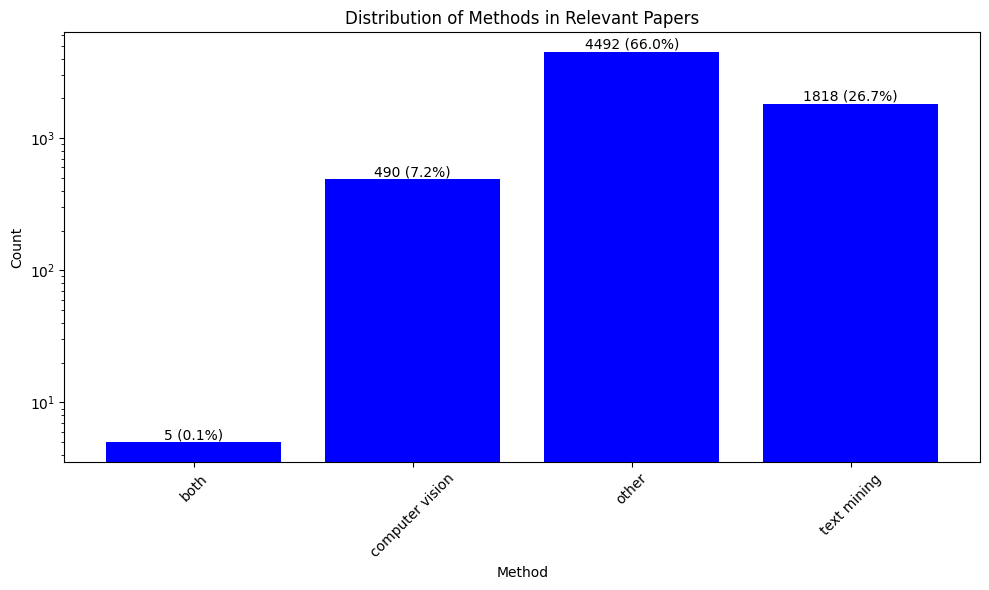

In [38]:
methods_type_report = revelant_data[['Title', 'method_group']].groupby('method_group').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_type_report['method_group'], methods_type_report['count'], color='blue')
plt.xlabel('Method')
plt.ylabel('Count')
plt.title('Distribution of Methods in Relevant Papers')
plt.xticks(rotation=45)
plt.yscale('log')

total_count = methods_type_report['count'].sum()
# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    percentage = (yval / total_count) * 100
    label = f'{int(yval)} ({percentage:.1f}%)'
    plt.text(bar.get_x() + bar.get_width()/2, yval, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()

# last step

In [39]:
# Function to extract method names from the abstract
def extract_methods(abstract):
    # Example patterns to identify methods


    # Find all methods mentioned in the abstract
    methods_found = [method for method in keywords if method in abstract]
    return ', '.join(methods_found)

In [40]:
revelant_data['method_used'] = revelant_data['titleAbstractNew'].apply(extract_methods)

revelant_data['method_used'].value_counts()

<ipython-input-40-31df08a7541c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revelant_data['method_used'] = revelant_data['titleAbstractNew'].apply(extract_methods)


,count
method_used,
deep learning,1274
neural network,964
"neural network, artificial neural network",668
"natural language processing, language processing",559
"natural language processing, nlp, language processing",331
...,...
"deep learning, neural network, convolutional neural network, cnn, natural language processing, nlp, language processing",1
"deep learning, neural network, convolutional neural network, recurrent neural network, transformer",1
"deep learning, neural network, transformer, natural language processing, language processing",1


In [41]:
def classify_method_by_keywords(method):
    method = method.lower()  # Normalize to lowercase
    if any(keyword in method for keyword in deep_learning_keywords):
        return 'Deep Learning'
    elif any(keyword in method for keyword in computer_vision_keywords):
        return 'Computer Vision'
    elif any(keyword in method for keyword in nlp_keywords):
        return 'Natural Language Processing'
    elif any(keyword in method for keyword in llm_keywords):
        return 'Large Language Model'
    else:
        return 'Other'


In [42]:
revelant_data['method'] = revelant_data['method_used'].apply(classify_method_by_keywords)
revelant_data['method'].value_counts()

<ipython-input-42-ed39d0dd4c42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revelant_data['method'] = revelant_data['method_used'].apply(classify_method_by_keywords)


,count
method,
Deep Learning,4658
Natural Language Processing,1670
Computer Vision,422
Large Language Model,55


In [43]:
methods_report = revelant_data[['Title', 'method']].groupby('method').size().reset_index(name='count')

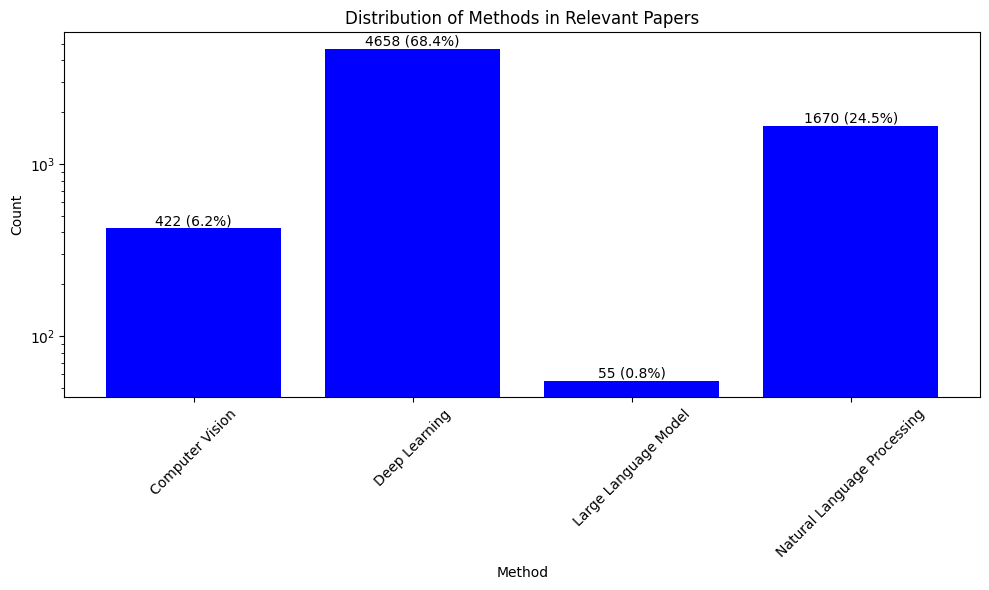

In [44]:
plt.figure(figsize=(10, 6))
bars = plt.bar(methods_report['method'], methods_report['count'], color='blue')
plt.xlabel('Method')
plt.ylabel('Count')
plt.title('Distribution of Methods in Relevant Papers')
plt.xticks(rotation=45)
plt.yscale('log')

total_count = methods_report['count'].sum()
# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    percentage = (yval / total_count) * 100
    label = f'{int(yval)} ({percentage:.1f}%)'
    plt.text(bar.get_x() + bar.get_width()/2, yval, label, ha='center', va='bottom')

plt.tight_layout()
plt.show()